In [27]:
from pyedflib import highlevel
import numpy as np
import pandas as pd
import peakutils
import scipy
from scipy import fftpack
from scipy import signal
from scipy.integrate import simps
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
#importing the required packages

In [8]:
File_Name='WTM41R_FPT' #Name of the file. Genotype followed by Sex followed by number followed by treatment condition

In [9]:
signals, signal_headers, header = highlevel.read_edf(File_Name+'.edf') 
#Reading the EDF file. The EDF file has 3 channels. It will get read as 3 rows in an array

In [10]:
Fs=2000
#Sampling frequency is 2000 Hz
time=300 #time in seconds that need to be analyzed

In [11]:
time_vec=np.arange(1,Fs*time+1)
#time vector

In [12]:
channel_data=[]
for i in range(len(signals)):
    s=signals[i]
    s=s[0:Fs*time]
    channel_data.append(s)
#channel data is now stored as 3 different channels for the desired time

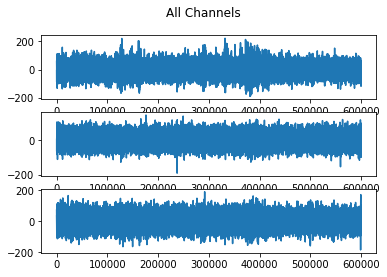

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.suptitle('All Channels')
ax1.plot(time_vec, channel_data[0])
ax2.plot(time_vec, channel_data[1])
ax3.plot(time_vec, channel_data[2])
#Plotting the raw Voltage data for the channels

Please refer to the following link for further details on the methods-
https://raphaelvallat.com/bandpower.html

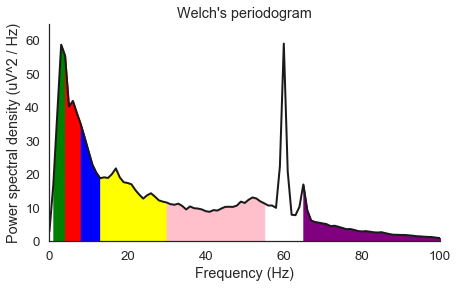

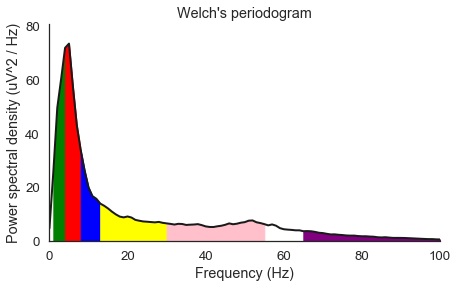

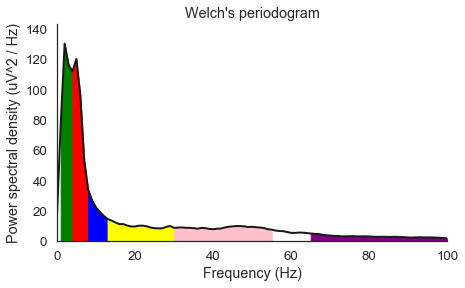

In [21]:
df=pd.DataFrame(columns=['Frequencies'])
df_2=pd.DataFrame(columns=['Bands'])
Bands=['Delta','Theta','Alpha','Beta','Low Gamma', 'High Gamma']
df_2['Bands']=Bands
for i in range(len(signals)):
    win =  1*Fs
    freqs, psd = signal.welch(signals[i], Fs, nperseg=win)
    freq_res = freqs[1] - freqs[0]
    df['Frequencies']=freqs
    df.insert(loc=i+1, column='Channel_'+ str(i+1), value=psd)
    # Plot the power spectrum
    sns.set(font_scale=1.2, style='white')
    low_delta, high_delta = 0.5, 4
    low_theta, high_theta = 4, 8
    low_alpha, high_alpha = 8, 13
    low_beta, high_beta = 13, 30
    low_lg, high_lg = 30, 55
    low_hg, high_hg = 65, 100
    # Find intersecting values in frequency vector
    idx_delta = np.logical_and(freqs >= low_delta, freqs <= high_delta)
    idx_theta = np.logical_and(freqs >= low_theta, freqs <= high_theta)
    idx_alpha = np.logical_and(freqs >= low_alpha, freqs <= high_alpha)
    idx_beta = np.logical_and(freqs >= low_beta, freqs <= high_beta)
    idx_lg = np.logical_and(freqs >= low_lg, freqs <= high_lg)
    idx_hg = np.logical_and(freqs >= low_hg, freqs <= high_hg)

    # Plot the power spectral density and fill the delta area
    plt.figure(figsize=(7, 4))
    plt.plot(freqs, psd, lw=2, color='k')
    plt.fill_between(freqs, psd, where=idx_delta, color='green')
    plt.fill_between(freqs, psd, where=idx_theta, color='red')
    plt.fill_between(freqs, psd, where=idx_alpha, color='blue')
    plt.fill_between(freqs, psd, where=idx_beta, color='yellow')
    plt.fill_between(freqs, psd, where=idx_lg, color='pink')
    plt.fill_between(freqs, psd, where=idx_hg, color='purple')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (uV^2 / Hz)')
    plt.xlim([0, 100])
    plt.ylim([0, psd.max() * 1.1])
    plt.title("Welch's periodogram")
    sns.despine()
    
    # Compute the absolute power by approximating the area under the curve
    delta_power = simps(psd[idx_delta], dx=freq_res)
    theta_power = simps(psd[idx_theta], dx=freq_res)
    alpha_power = simps(psd[idx_alpha], dx=freq_res)
    beta_power = simps(psd[idx_beta], dx=freq_res)
    lg_power = simps(psd[idx_lg], dx=freq_res)
    hg_power = simps(psd[idx_hg], dx=freq_res)
    Powers=[delta_power,theta_power,alpha_power,beta_power,lg_power,hg_power]
    df_2.insert(loc=i+1, column=i+1, value=Powers)
    #print('Absolute delta power: %.3f uV^2' % delta_power)
    #print('Absolute alpha power: %.3f uV^2' % alpha_power)
    #print('Absolute beta power: %.3f uV^2' % beta_power)
    #print('Absolute low gamma power: %.3f uV^2' % lg_power)
    #print('Absolute high gamma power: %.3f uV^2' % hg_power)

In [22]:
#Fixing the Data Frames
Final_Welch_Data=df.head(101)
Power_bands=df_2

In [25]:
#Exporting the Data Frames as CSV
Final_Welch_Data.to_csv(str(File_Name)+'_Welch.csv',index=False)
Power_bands.to_csv(str(File_Name)+'_EEG_Bands.csv',index=False)

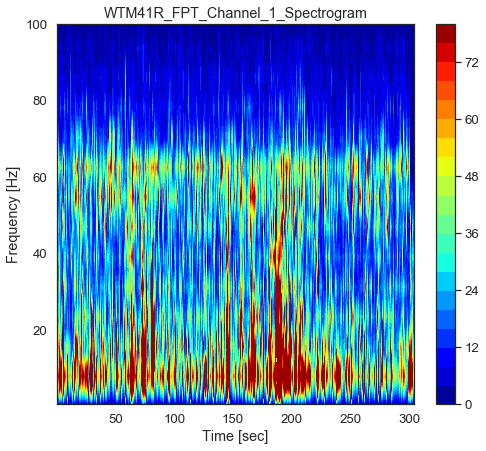

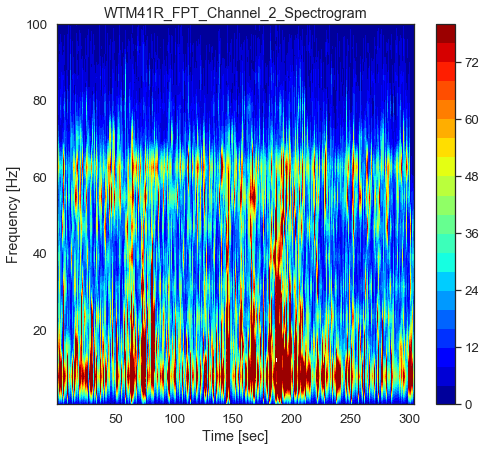

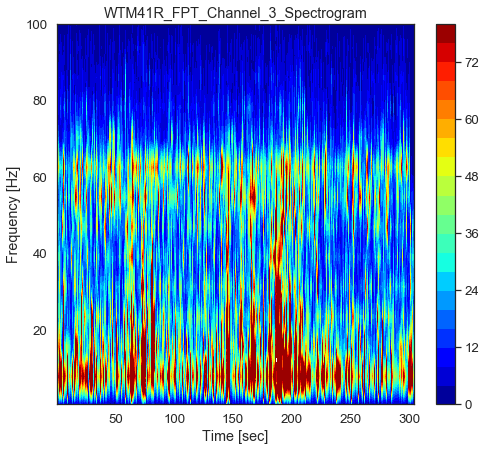

In [34]:
#Plotting the Spectrogram for all 3 channels
for i in range(len(signals)):
    fig, ax = plt.subplots(figsize=(8, 7))
    f, t, Sxx = scipy.signal.spectrogram(signals[0], Fs)
    levels = MaxNLocator(nbins=20).tick_values(0, 80)
    cmap = plt.get_cmap('jet')
    norm=BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    im=ax.contourf(t, f, Sxx,levels=levels ,cmap=cmap) #,norm=norm)
    fig.colorbar(im, ax=ax)
    ax.set_title(File_Name +'_Channel_'+ str(i+1) + '_Spectrogram')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    plt.ylim([0.5, 100])
    fig.savefig(File_Name +'_Channel_'+ str(i+1) + '_Spectrogram.png')
